In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import os
import random
from torchvision.utils import save_image

In [ ]:
# Function to check if a patch is black
def is_patch_black(patch, threshold):
    """
    Check if a patch is considered black based on a given threshold.
    """
    threshold = 0.6
    imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Denormalize patch
    denormalized_patch = patch * imagenet_std + imagenet_mean
    
    # Compute deviation from black (0,0,0)
    deviation = torch.abs(denormalized_patch - 0.0)
    
    # Max deviation across channels
    max_deviation = deviation.max()
    
    return max_deviation, max_deviation < threshold # for zero 

# Directory containing training images
training_data_dir = "images/train/"  # <-- Change this to your dataset directory

# Recursively get all image files in subdirectories
image_files = []
for root, _, files in os.walk(training_data_dir):
    for file in files:
        if file.endswith((".png", ".jpg", ".jpeg")):
            image_files.append(os.path.join(root, file))

# Randomly sample n images
num_samples = 1
sampled_images = random.sample(image_files, min(num_samples, len(image_files)))

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert image to tensor (C, H, W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Apply ImageNet normalization
])

# Define patch size
patch_size = 14  # Change as needed

black_deviation_values = []
non_black_deviation_values = []
is_black_values = []

# Directory to save patches
patch_save_dir = "image_patches/"

# Define sub-directories for saving patches
black_patch_dir = os.path.join(patch_save_dir, "black")
non_black_patch_dir = os.path.join(patch_save_dir, "non_black")

# Create directories
os.makedirs(black_patch_dir, exist_ok=True)
os.makedirs(non_black_patch_dir, exist_ok=True)

# Process each sampled image
for image_path in sampled_images:
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)  # (C, H, W)

    # Compute number of patches
    C, H, W = image_tensor.shape
    H_patches = H // patch_size
    W_patches = W // patch_size

    # Iterate over patches
    for i in range(H_patches):
        for j in range(W_patches):
            r_start, c_start = i * patch_size, j * patch_size
            patch = image_tensor[:, r_start:r_start + patch_size, c_start:c_start + patch_size]
            
            deviation, is_black = is_patch_black(patch, threshold=1e-2)  # Initial threshold guess
            if is_black:
                # Save black patch image
                patch_filename = f"{image_path.split('/')[-1].split('.')[0]}_patch_{i}_{j}.png"
                patch_path = os.path.join(black_patch_dir ,patch_filename)
                save_image(patch, patch_path)   # Save the patch
                is_black_values.append(is_black)
                black_deviation_values.append(deviation.item())

            else:
                # Save non-black patch image
                patch_filename = f"{image_path.split('/')[-1].split('.')[0]}_patch_{i}_{j}.png"
                patch_path = os.path.join(non_black_patch_dir ,patch_filename)
                non_black_deviation_values.append(deviation.item())
                save_image(patch, patch_path)   # Save the patch
            
                
                


/tmp/ipykernel_84199/1971369814.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


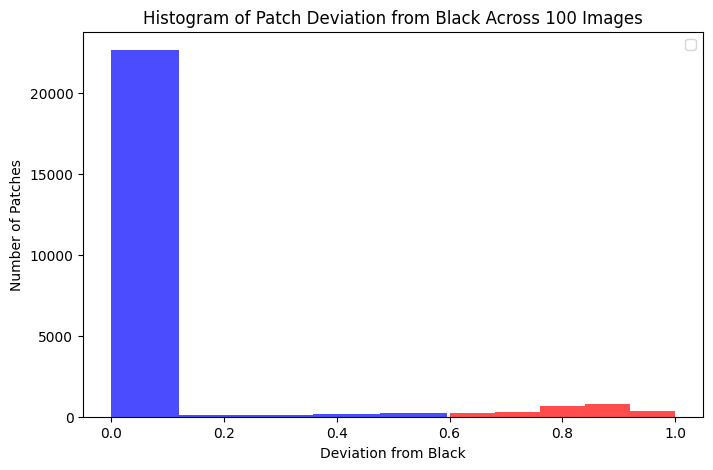

Suggested threshold: 0.00000


In [80]:
# Plot histogram of deviations across all 20 images
plt.figure(figsize=(8, 5))
plt.hist(black_deviation_values, bins=5, color="blue", alpha=0.7)
plt.hist(non_black_deviation_values, bins=5, color="red", alpha=0.7)
# plt.axvline(2.9802322387695312e-08, color="red", linestyle="dashed", label=f"Threshold = 0.01")

plt.ylabel("Number of Patches")
plt.xlabel("Deviation from Black")
plt.title("Histogram of Patch Deviation from Black Across 100 Images")
plt.legend()
plt.show()

# Suggest threshold
suggested_threshold = np.percentile(black_deviation_values, 95)  # Pick a low percentile
print(f"Suggested threshold: {suggested_threshold:.5f}")



In [74]:
np.percentile(black_deviation_values, 75)

np.float64(2.9802322387695312e-08)

In [49]:
unique_values = list(set(non_black_deviation_values)) # Get unique values


In [50]:
unique_values.sort() # Sort the unique values

In [51]:
unique_values[:3]

[0.03529411554336548, 0.04313725233078003, 0.05098038911819458]